In [1]:
import sys
import warnings
sys.path.append('../')
warnings.filterwarnings('ignore')

%matplotlib widget
%load_ext autoreload
%autoreload 1
%aimport utils, GroupingAlgorithm, HEEM_VQE_Functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.auto import tqdm
from os.path import isfile

from qiskit import IBMQ, Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.utils.quantum_instance import QuantumInstance
from qiskit.ignis.verification import get_ghz_simple
from qiskit.compiler import transpile
from qiskit.tools.monitor import job_monitor
from qiskit.opflow.state_fns import CircuitStateFn
from qiskit.providers.aer.extensions.snapshot_statevector import *

from utils import get_backend_connectivity, molecules, Label2Chain, from_string_to_numbers, load_grouping_data, current_time, load_data_IBMQ, send_ibmq_parallel
from GroupingAlgorithm import groupingWithOrder, TPBgrouping
from HEEM_VQE_Functions import measure_circuit_factor, probability2expected_binary, post_process_results, probability2expected_parallel, post_process_results_2, post_process_results_3

In [3]:
def compute_energy(Groups, Measurements, method, n_chunks=10, layout=None, return_energy_temp=False):
    
    circuits = [measure_circuit_factor(measurement, n_qubits, measure_all=False).compose(state_0, front=True) for measurement
                 in Measurements]
    
    kwards_run = {'coupling_map': coupling_map, 'noise_model': noise_model, 'basis_gates': basis_gates, 'shots': NUM_SHOTS // len(Groups)}
    
    if layout is not None:
        kwards_run['initial_layout'] = layout[::-1]
    
    jobs = send_ibmq_parallel(backed_calculations, n_chunks, circuits, job_tag=[molecule_name, method], verbose=False,
                              progress_bar=True, output_file='progress_' + method + '.txt', kwards_run=kwards_run)

    counts = []
    
    for job in jobs:
        counts += job.result().get_counts()
    
    energy_temp = []
    pbar = tqdm(range(len(counts)), desc='Computing energy')
    for j in pbar:
        # probabilities = post_process_results(counts[j], circuits[j].num_clbits, kwards_run['shots'])
        probabilities = post_process_results_2(counts[j], circuits[j].num_clbits)
        
        diagonals, factors = probability2expected_binary(coeffs, labels, [Groups[j]], [Measurements[j]], shift=False)
        diagonals = [(~diagonal * 2 - 1).astype('int8') for diagonal in diagonals[0]]
        
        # energy_temp.append(np.sum((diagonals * np.array(factors[0])[:, None]) @ probabilities))
        energy_temp.append(np.sum((diagonals * np.array(factors[0])[:, None]) @ probabilities) / kwards_run['shots'])

    returns = [jobs, sum(energy_temp)]
    
    if return_energy_temp:
        returns.append(energy_temp)
        
    return returns

In [63]:
def compute_energy_sparse(Groups, Measurements, method, n_chunks=10, layout=None, return_energy_temp=False):
    
    circuits = [measure_circuit_factor(measurement, n_qubits, measure_all=False).compose(state_0, front=True) for measurement
                 in Measurements]
    
    # circuits = transpile(circuits, backend)
    
    kwards_run = {'coupling_map': coupling_map, 'noise_model': noise_model, 'basis_gates': basis_gates, 'shots': NUM_SHOTS // len(Groups)}
    
    if layout is not None:
        kwards_run['initial_layout'] = layout[::-1]
    
    jobs = send_ibmq_parallel(backed_calculations, n_chunks, circuits, job_tag=[molecule_name, method], verbose=False,
                              progress_bar=True, output_file='progress_' + method + '.txt', kwards_run=kwards_run)

    counts = []
    
    for job in jobs:
        counts += job.result().get_counts()
    
    energy_temp = []
    pbar = tqdm(range(len(counts)), desc='Computing energy')
    for j in pbar:
        counts_indices, counts_values = post_process_results_3(counts[j])

        diagonals, factors = probability2expected_binary(coeffs, labels, [Groups[j]], [Measurements[j]], shift=False)
        diagonals = [(~diagonal * 2 - 1).astype('int8') for diagonal in diagonals[0][:, counts_indices]]

        energy_temp.append(np.sum((diagonals * np.array(factors[0])[:, None]) * counts_values[None, :]) / kwards_run['shots'])

    returns = [jobs, sum(energy_temp)]
    
    if return_energy_temp:
        returns.append(energy_temp)
        
    return returns

In [5]:
def save_data(energy, method):
    file = '../data/energies/' + initial_state +'/' + molecule_name + '_' + method + '.npy'
    if isfile(file):
        data = np.load(file)
    else:
        data = np.array([])
    
    data = np.append(data, energy)
    np.save(file, data)

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    IBMQ.load_account()

provider_main = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider_CSIC = IBMQ.get_provider(hub='ibm-q-csic', group='internal', project='iff-csic')

name_backend = 'ibmq_montreal'
backend = provider_CSIC.get_backend(name_backend)
WC_device = get_backend_connectivity(backend)

G_device = nx.Graph()
G_device.add_edges_from(WC_device)

In [7]:
NUM_SHOTS = 2 ** 14

backend_hpc = provider_main.get_backend('ibmq_qasm_simulator')
backed_simulation = provider_main.get_backend('simulator_statevector')
simulator = Aer.get_backend('aer_simulator')  # Backend for simulation

device = QasmSimulator.from_backend(backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

backed_calculations = backend_hpc

In [100]:
molecule_name = 'LiH'
initial_state = '0xN'

try:
    qubit_op = molecules(molecule_name)
    paulis, coeffs, labels = Label2Chain(qubit_op)
except AttributeError:
    paulis, coeffs, labels = np.load('../data/molecules_qubitop_list.npy', allow_pickle=True).item()[molecule_name]

n_qubits = len(paulis[0])
state_0 = QuantumCircuit(n_qubits)
# state_0 = state_0.compose(get_ghz_simple(n_qubits, measure=False))  # Initialized in the GHZ state

print(f'{len(paulis)} total Pauli strings')
print(f'{n_qubits} qubits')

Molecule loaded
100 total Pauli strings
4 qubits


# Exact analytical

## $|0\rangle^{\otimes N}$

In [101]:
if initial_state == '0xN':
    energy_exact = 0

    for i in range(len(labels)):
        label = labels[i]
        if 'X' not in label and 'Y' not in label:
            energy_exact += coeffs[i]
    print('Exact energy: {}'.format(energy_exact))

Exact energy: -0.5510251881566791


## $|\mathrm{GHZ}\rangle$

In [106]:
if initial_state == 'GHZ':
    diagonals = {'I': np.array([1, 0, 0, 1]), 'X': np.array([0, 1, 1, 0]),
                 'Y': np.array([0, 1j, -1j, 0]), 'Z': np.array([1, 0, 0, -1])}

    energy_exact = 0
    for label, coeff in zip(labels, coeffs):
        diagonal = np.ones(4, dtype=complex)
        for op in label:
            diagonal *= diagonals[op]
        energy_exact += coeff * np.sum(diagonal) / 2

    print('Exact energy: {}'.format(energy_exact.real))

# Exact (Numerical)

psi = CircuitStateFn(state_0)
energy_exact = psi.adjoint().compose(qubit_op).compose(psi).eval().real
    
print('Exact energy: {}'.format(energy_exact))

# Exact (Simulation)

In [8]:
Groups, Measurements, _ = load_grouping_data(molecule_name, 'EM')
# Groups, Measurements, _ = groupingWithOrder(paulis, connected=True, print_progress=True)
print('Number of groups: {}'.format(len(Groups)))

circuits_exact = []
for j, measure in enumerate(Measurements):
    circuit = measure_circuit_factor(measure, n_qubits, make_measurements=False)
    circuit = circuit.compose(state_0, front=True)
    # circuit.save_statevector()
    circuit.snapshot_statevector('snapshot')
    circuits_exact.append(circuit)

Data loaded
Number of groups: 682


C:\Users\david\anaconda3\envs\heem\lib\site-packages\qiskit\providers\aer\extensions\snapshot_statevector.py:86: DeprecationWarning: The `SnapshotStatevector` instruction will be deprecated in thefuture. It has been superseded by the `SaveStatevector` instructions.
  SnapshotStatevector(label, num_qubits=len(snapshot_register)),
C:\Users\david\anaconda3\envs\heem\lib\site-packages\qiskit\providers\aer\extensions\snapshot_statevector.py:49: DeprecationWarning: The `Snapshot` instruction will be deprecated in the future. It has been superseded by the `SaveStatevector` instructions.
  super().__init__(label, snapshot_type='statevector', num_qubits=num_qubits)


In [9]:
depth = []
for circuit in circuits_exact:
    depth.append(circuit.depth())
    
print(np.average(depth), np.median(depth), np.max(depth))

3.1510263929618767 3.0 4


In [10]:
n_max = 25

if n_max == -1:
    n_max = len(circuits_exact)
n_runs = int(np.ceil(len(circuits_exact) / n_max))

In [27]:
jobs = send_ibmq_parallel(backed_calculations, n_max, circuits_exact, job_tag=molecule_name, kwards_run={'shots': 1}, progress_bar=True)
jobs_ids = [job.job_id() for job in jobs]

np.save(molecule_name + '_exact_job_ids.npy', jobs_ids)

Jobs completed:   0%|          | 0/5 [00:00<?, ?it/s]

Job 1/5 sent to IBMQ
Job 2/5 sent to IBMQ
Job 3/5 sent to IBMQ
Job 4/5 sent to IBMQ
Job 5/5 sent to IBMQ


In [11]:
jobs_ids = np.load(molecule_name + '_exact_job_ids.npy').tolist()

In [13]:
energy_exact = 0

pbar = tqdm(total=len(jobs_ids), desc='Computing exact energy')
for i in range(len(jobs_ids)):
    prob = load_data_IBMQ(jobs_ids[i], verbose=True)
    
    initial = i * n_max
    final = min(initial + n_max, len(circuits_exact))
    
    temp = probability2expected_parallel(-1, coeffs, labels, Groups[initial:final], Measurements[initial:final], shift=True, print_progress=True)
    diagonals = [x[0] for x in temp]
    factors = [x[1] for x in temp]
    
    diagonals = [(~diagonal * 2 - 1).astype('int8') for diagonal in diagonals]
    
    for j in range(len(diagonals)):
        energy_exact += np.sum((diagonals[j] * np.array(factors[j])[:, None]) @ prob[j])
        
    pbar.update()
pbar.close()
print('Exact energy: {}'.format(energy_exact))

Computing exact energy:   0%|          | 0/28 [00:00<?, ?it/s]

data downloaded
Loading data...


Computing diagonal factors:   0%|          | 0/24 [00:00<?, ?it/s]

KeyboardInterrupt: 

# TPB

In [102]:
temp = load_grouping_data(molecule_name, 'TPB')
# temp = None

if temp is not None:
    Groups, Measurements = temp
else:
    _, Groups, Measurements = TPBgrouping(paulis, print_progress=True)

print('Number of groups', len(Groups))

Number of groups 25


In [103]:
method = 'TPB'

n_repeats = 25

for _ in range(n_repeats):
    jobs_TPB, energy_TPB, energies_TPB_temp = compute_energy_sparse(Groups, Measurements, method, n_chunks=300, return_energy_temp=True)
    relative_TPB = np.abs((energy_TPB - energy_exact) / energy_exact)

    print('TPB energy: {}'.format(energy_TPB))
    print('Relative error: {:.3f} %'.format(relative_TPB * 100))

    time = sum((job.time_per_step()['COMPLETED'] - job.time_per_step()['RUNNING']).total_seconds() for job in jobs_TPB)
    print(f'Simulation time {time} s')

    with open('progress_' + method + '.txt', 'w') as f:
        f.write('Done: {}\n'.format(energy_TPB))

    save_data(energy_TPB, method)

Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/25 [00:00<?, ?it/s]

TPB energy: -0.5383326046499145
Relative error: 2.303 %
Simulation time 12110.983 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/25 [00:00<?, ?it/s]

TPB energy: -0.5429005457982997
Relative error: 1.474 %
Simulation time 2.735 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/25 [00:00<?, ?it/s]

TPB energy: -0.5375633966540851
Relative error: 2.443 %
Simulation time 2.394 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/25 [00:00<?, ?it/s]

TPB energy: -0.540681394181628
Relative error: 1.877 %
Simulation time 13723.411 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/25 [00:00<?, ?it/s]

TPB energy: -0.532296486770539
Relative error: 3.399 %
Simulation time 2.503 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/25 [00:00<?, ?it/s]

TPB energy: -0.5476969475728817
Relative error: 0.604 %
Simulation time 2.55 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/25 [00:00<?, ?it/s]

TPB energy: -0.5441105004280452
Relative error: 1.255 %
Simulation time 2.805 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/25 [00:00<?, ?it/s]

TPB energy: -0.5314051696288145
Relative error: 3.561 %
Simulation time 2.641 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/25 [00:00<?, ?it/s]

TPB energy: -0.539767689903399
Relative error: 2.043 %
Simulation time 2.205 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/25 [00:00<?, ?it/s]

TPB energy: -0.5362205880557489
Relative error: 2.687 %
Simulation time 2.377 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/25 [00:00<?, ?it/s]

TPB energy: -0.5414472177334222
Relative error: 1.738 %
Simulation time 13610.88 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/25 [00:00<?, ?it/s]

TPB energy: -0.5418221165744016
Relative error: 1.670 %
Simulation time 3.451 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/25 [00:00<?, ?it/s]

TPB energy: -0.5416598532385928
Relative error: 1.700 %
Simulation time 3.684 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/25 [00:00<?, ?it/s]

TPB energy: -0.5431319896365989
Relative error: 1.432 %
Simulation time 2.541 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/25 [00:00<?, ?it/s]

TPB energy: -0.5440210594381075
Relative error: 1.271 %
Simulation time 2.281 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/25 [00:00<?, ?it/s]

TPB energy: -0.5445361721874836
Relative error: 1.178 %
Simulation time 2.167 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/25 [00:00<?, ?it/s]

TPB energy: -0.548870631617372
Relative error: 0.391 %
Simulation time 13637.711 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/25 [00:00<?, ?it/s]

TPB energy: -0.5443903395235942
Relative error: 1.204 %
Simulation time 6.064 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/25 [00:00<?, ?it/s]

TPB energy: -0.5474186052967194
Relative error: 0.655 %
Simulation time 2.545 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/25 [00:00<?, ?it/s]

TPB energy: -0.5533073838242992
Relative error: 0.414 %
Simulation time 13717.611 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/25 [00:00<?, ?it/s]

TPB energy: -0.5389532837074575
Relative error: 2.191 %
Simulation time 2.253 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/25 [00:00<?, ?it/s]

TPB energy: -0.5381778105565757
Relative error: 2.332 %
Simulation time 2.589 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/25 [00:00<?, ?it/s]

TPB energy: -0.5424549788892084
Relative error: 1.555 %
Simulation time 2.42 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/25 [00:00<?, ?it/s]

TPB energy: -0.5498187077249688
Relative error: 0.219 %
Simulation time 2.528 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/25 [00:00<?, ?it/s]

TPB energy: -0.5393039847939978
Relative error: 2.127 %
Simulation time 2.273 s


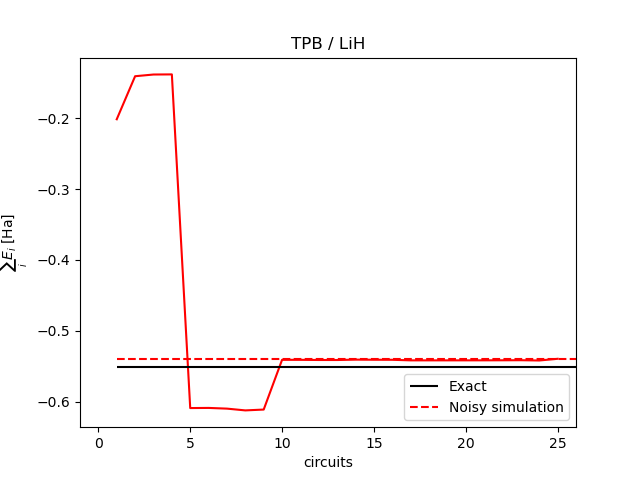

In [104]:
fig, ax = plt.subplots()

data = np.array(energies_TPB_temp)
x = np.arange(1, len(data) + 1)
mask = data > 0

ax.plot(x, np.cumsum(data), 'r')
ax.hlines(energy_exact, 1, len(data) + 1, color='k', label='Exact')
ax.hlines(sum(data), 1, len(data) + 1, color='r', ls='--', label='Noisy simulation')

# ax.plot(x, np.abs(data))

# ax.bar(x[mask], np.abs(data)[mask], width=1, color='b', label=r'$E_i>0$')
# ax.bar(x[~mask], np.abs(data)[~mask], width=1, color='r', label=r'$E_i\leq0$')

ax.set_xlim(-1, len(data) + 1)
ax.set_xlabel('circuits')
# ax.set_ylabel(r'$|E_i|$ [Ha]')
ax.set_ylabel(r'$\sum_{i}^n E_i$ [Ha]')

# ax.set_yscale('log')

ax.legend(loc=4)
ax.set_title(f'{method} / {molecule_name}');

# EM

In [105]:
temp = load_grouping_data(molecule_name, 'EM')
# temp = None

if temp is not None:
    Groups, Measurements, layout = temp
else:
    Groups, Measurements, layout = groupingWithOrder(paulis, connected=True, print_progress=True)

missing = []
for i in range(np.max(np.array(WC_device)) + 1):
    if i not in layout:
        missing.append(i)    

# layout = (layout[::-1] + missing)[::-1]
    
print('Number of groups', len(Groups))

Number of groups 11


In [ ]:
method = 'EM'

n_repeats = 25

for _ in range(n_repeats):
    jobs_EM, energy_EM, energies_EM_temp = compute_energy_sparse(Groups, Measurements, method, layout=layout, n_chunks=100, return_energy_temp=True)
    relative_EM= np.abs((energy_EM - energy_exact) / energy_exact)

    print('EM energy: {}'.format(energy_EM))
    print('Relative error: {:.3f} %'.format(relative_EM * 100))

    time = sum((job.time_per_step()['COMPLETED'] - job.time_per_step()['RUNNING']).total_seconds() for job in jobs_EM)
    print(f'Simulation time {time} s')

    with open('progress_' + method + '.txt', 'w') as f:
        f.write('Done: {}\n'.format(energy_EM))

    save_data(energy_EM, method)

Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/11 [00:00<?, ?it/s]

EM energy: -0.551296711354084
Relative error: 0.049 %
Simulation time 1.599 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/11 [00:00<?, ?it/s]

EM energy: -0.5589081789448684
Relative error: 1.431 %
Simulation time 1.926 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/11 [00:00<?, ?it/s]

EM energy: -0.5508471608322028
Relative error: 0.032 %
Simulation time 1.872 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

Computing energy:   0%|          | 0/11 [00:00<?, ?it/s]

EM energy: -0.5577294164307577
Relative error: 1.217 %
Simulation time 1.751 s


Jobs completed:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
fig, ax = plt.subplots()

data = np.array(energies_EM_temp)
x = np.arange(1, len(data) + 1)
mask = data > 0

ax.plot(x, np.cumsum(data), 'r')
ax.hlines(energy_exact, 1, len(data) + 1, color='k', label='Exact')
ax.hlines(sum(data), 1, len(data) + 1, color='r', ls='--', label='Noisy simulation')

# ax.plot(x, np.abs(data))

# ax.bar(x[mask], np.abs(data)[mask], width=1, color='b', label=r'$E_i>0$')
# ax.bar(x[~mask], np.abs(data)[~mask], width=1, color='r', label=r'$E_i\leq0$')

ax.set_xlim(-1, len(data) + 1)
ax.set_xlabel('circuits')
# ax.set_ylabel(r'$|E_i|$ [Ha]')
ax.set_ylabel(r'$\sum_{i}^n E_i$ [Ha]')

# ax.set_yscale('log')

ax.legend(loc=4)
ax.set_title(f'{method} / {molecule_name}');

# HEEM

In [ ]:
temp = load_grouping_data(molecule_name, 'HEEM')
# temp = None

if temp is not None:
    Groups, Measurements, layout = temp
else:
    Groups, Measurements, layout = groupingWithOrder(paulis, G_device, connected=True, print_progress=True)

missing = []
for i in range(np.max(np.array(WC_device)) + 1):
    if i not in layout:
        missing.append(i)    

# layout = (layout[::-1] + missing)[::-1]

print('Number of groups', len(Groups))

In [ ]:
method = 'HEEM'

n_repeats = 25

for _ in range(n_repeats):
    jobs_HEEM, energy_HEEM, energies_HEEM_temp = compute_energy_sparse(Groups, Measurements, method, n_chunks=300, layout=layout, return_energy_temp=True)
    relative_HEEM = np.abs((energy_HEEM - energy_exact) / energy_exact)

    print('HEEM energy: {}'.format(energy_HEEM))
    print('Relative error: {:.3f} %'.format(relative_HEEM * 100))

    time = sum((job.time_per_step()['COMPLETED'] - job.time_per_step()['RUNNING']).total_seconds() for job in jobs_HEEM)
    print(f'Simulation time {time} s')

    with open('progress_' + method + '.txt', 'w') as f:
        f.write('Done: {}\n'.format(energy_HEEM))

    save_data(energy_HEEM, method)

In [ ]:
fig, ax = plt.subplots()

data = np.array(energies_HEEM_temp)
x = np.arange(1, len(data) + 1)
mask = data > 0

ax.plot(x, np.cumsum(data), 'r')
ax.hlines(energy_exact, 1, len(data) + 1, color='k', label='Exact')
ax.hlines(sum(data), 1, len(data) + 1, color='r', ls='--', label='Noisy simulation')

# ax.plot(x, np.abs(data))

# ax.bar(x[mask], np.abs(data)[mask], width=1, color='b', label=r'$E_i>0$')
# ax.bar(x[~mask], np.abs(data)[~mask], width=1, color='r', label=r'$E_i\leq0$')

ax.set_xlim(-1, len(data) + 1)
ax.set_xlabel('circuits')
# ax.set_ylabel(r'$|E_i|$ [Ha]')
ax.set_ylabel(r'$\sum_{i}^n E_i$ [Ha]')

# ax.set_yscale('log')

ax.legend(loc=4)
ax.set_title(f'{method} / {molecule_name}');